# Assignment 18/02/2025

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## CT1 Segmentation

### Image loading, conversion to grayscale

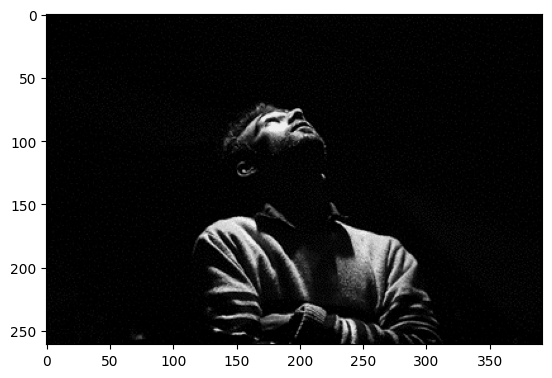

In [ ]:
ct_segment_image = cv2.imread("../images/CT1_segment.png")
grayscale = cv2.cvtColor(ct_segment_image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale, cmap='gray', vmin=0, vmax=255)

### Image Enhancement - Histogram Equalization

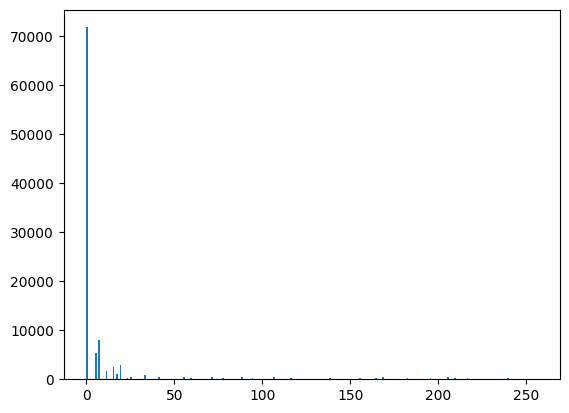

In [3]:
# FROM DOCUMENTATION: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
_ = plt.hist(grayscale.ravel(), 256, [0,256])

In [4]:
equalized = cv2.equalizeHist(grayscale)

clahe = cv2.createCLAHE()
cl1 = clahe.apply(grayscale)

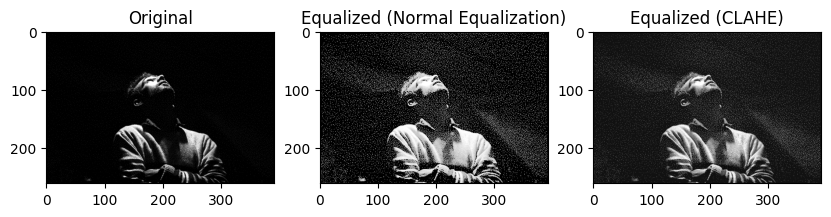

In [5]:
plt.figure(figsize=(10, 15))

plt.subplot(1, 3, 1)
plt.imshow(grayscale, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(equalized, cmap='gray')
plt.title(f"Equalized (Normal Equalization)")

plt.subplot(1, 3, 3)
plt.imshow(cl1, cmap='gray')
plt.title(f"Equalized (CLAHE)")

plt.show()

### Image Segmentation - Automatic Thresholding

In [6]:
T = 200
break_thresh = 0.01
del_T = break_thresh + 1 # to enter the loop

In [7]:
while(del_T > break_thresh):
    G1 = cl1[cl1 <= T]
    G2 = cl1[cl1 > T]
    
    mu1 = G1.mean()
    mu2 = G2.mean()
    
    new_T = (mu1 + mu2) / 2
    del_T = abs(new_T - T)
    T = new_T

In [8]:
def threshold(x, thresh=T):
    return 0 if x <= thresh else 255

bw_fun_auto = np.vectorize(threshold)
auto_thresh_result = bw_fun_auto(cl1)

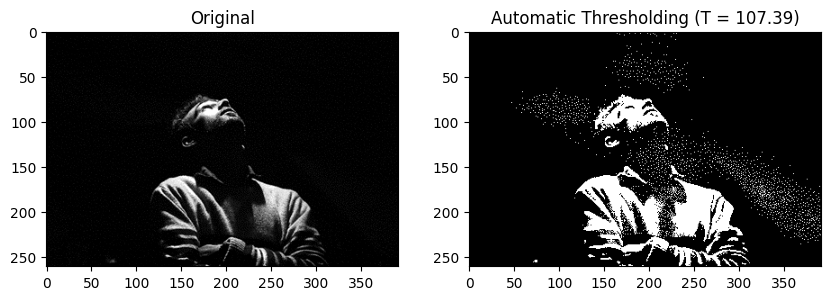

In [9]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(auto_thresh_result, cmap='gray')
plt.title(f"Automatic Thresholding (T = {T:.2f})")

plt.show()

## Corner Detection

### Image loading, conversion to grayscale

In [ ]:
corner_detection_image = cv2.imread("../images/corner_detection.png").astype(np.float32)

In [11]:
grayscale_corner_detect = cv2.cvtColor(corner_detection_image, cv2.COLOR_BGR2GRAY)

### Harris Corner Detection

#### Defining kernels

In [12]:
# Sobel
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

#### Derivatives, convolutions and corner response

In [13]:
def corner_response(image, k, Sx=Sx, Sy=Sy, G=G):
    # compute first derivatives
    Ix = cv2.filter2D(image, ddepth=-1, kernel=Sx)
    Iy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

    # Gaussian Filter (blur)
    A = cv2.filter2D(Ix*Ix, ddepth=-1, kernel=G)
    B = cv2.filter2D(Iy*Iy, ddepth=-1, kernel=G)
    C = cv2.filter2D(Ix*Iy, ddepth=-1, kernel=G)

    # compute corner response at all pixels
    return (A*B - (C*C)) - k*(A + B)*(A + B) # det(M) - k tr(M)^2

In [14]:
def get_harris_corners(image, k=0.05, Sx=Sx, Sy=Sy, G=G):
    # compute corner response
    R = corner_response(image, k, Sx=Sx, Sy=Sy, G=G)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(R > 1e-2))
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    
    # FROM DOCUMENTATION: Refines the corner locations. The function iterates to find the sub-pixel accurate location of corners
    return cv2.cornerSubPix(image, np.float32(centroids), (9,9), (-1,-1), criteria) 

#### Application and plotting

In [15]:
# 0-1 normalize
grayscale_corner_detect /= grayscale_corner_detect.max()

# find corners
corners = get_harris_corners(grayscale_corner_detect)

# draw corners on output image
image_out = np.dstack((grayscale_corner_detect, grayscale_corner_detect, grayscale_corner_detect))
for (x, y) in corners:
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    cv2.circle(image_out, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


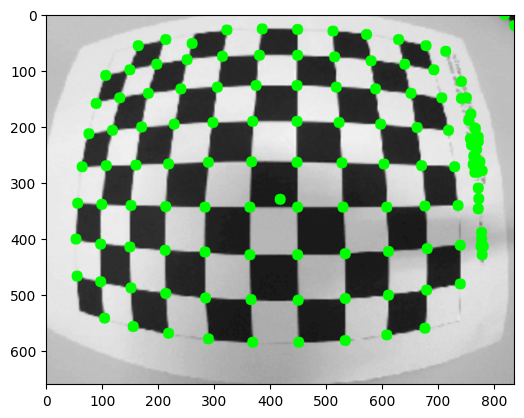

In [16]:
plt.imshow(image_out, cmap='gray')

### Shi-Tomasi Corner Detection

#### Parameters

In [17]:
maxCorners = 100
qualityLevel = 0.01
minDistance = 10
blockSize = 3
gradientSize = 3
useHarrisDetector = False
k = 0.04

#### Application and plotting

In [18]:
corners = cv2.goodFeaturesToTrack(grayscale_corner_detect, maxCorners, qualityLevel, minDistance, None, \
        blockSize=blockSize, gradientSize=gradientSize, useHarrisDetector=useHarrisDetector, k=k)
corners = np.intp(corners)

# draw corners on output image
image_out = np.dstack((grayscale_corner_detect, grayscale_corner_detect, grayscale_corner_detect))
for i in corners:
    x, y = i.ravel()
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    cv2.circle(image_out, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


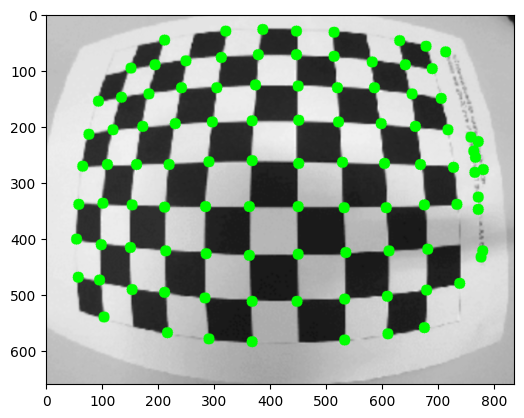

In [19]:
plt.imshow(image_out, cmap='gray')

## Visual Features - Descriptors

### Feature match loading, conversion to grayscale

In [ ]:
original_image = cv2.imread('../images/template_matching.png')
match_image = cv2.imread('../images/feature_descriptor.png')   

In [21]:
grayscale_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
grayscale_match = cv2.cvtColor(match_image, cv2.COLOR_BGR2GRAY) 

Text(0.5, 1.0, 'Match')

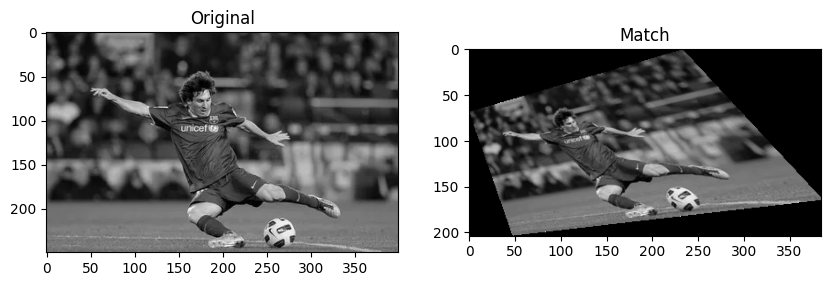

In [22]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_original, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(grayscale_match, cmap='gray')
plt.title("Match")

### SIFT (Scale-Invariant Feature Transform)

In [23]:
# Detect SIFT keypoints and descriptors in the images
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(grayscale_original, None)
keypoints2, descriptors2 = sift.detectAndCompute(grayscale_match, None)

In [24]:
# Use the BFMatcher to find the best matches between the descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

In [25]:
# Define a threshold for the ratio test
threshold = 0.4

# Filter the matches using the Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < threshold * n.distance:
        good_matches.append(m)

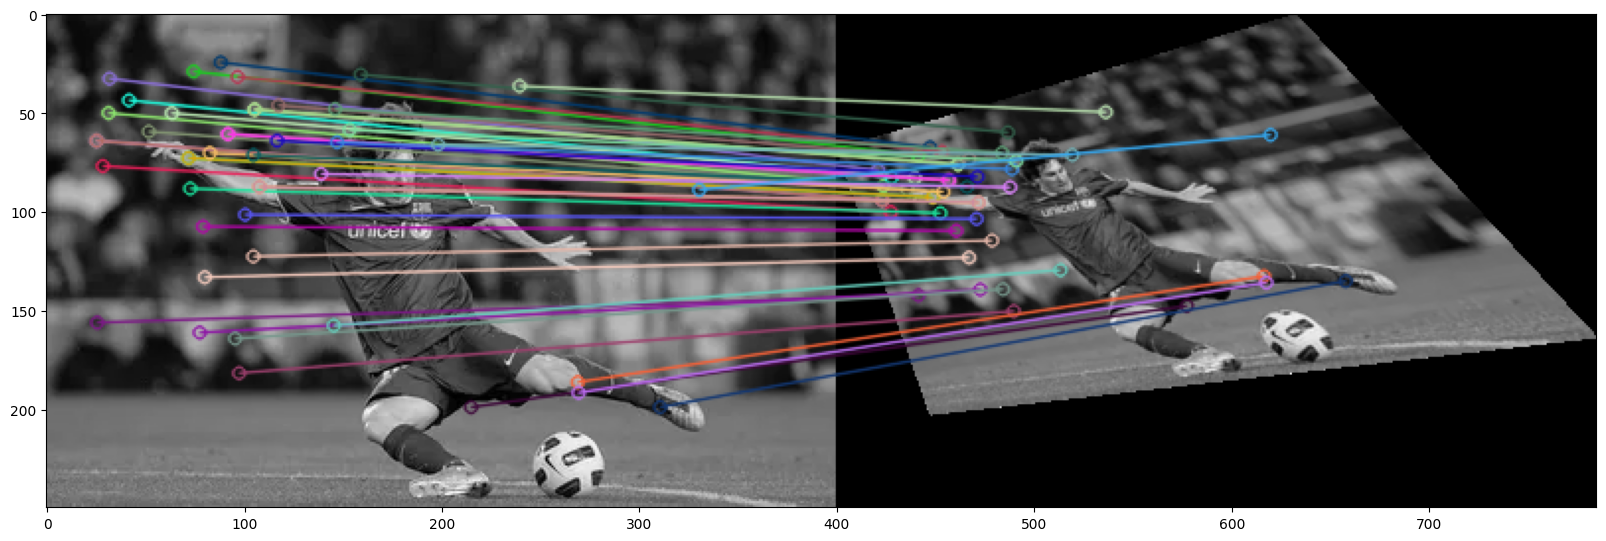

In [26]:
# Draw the matches on the images, display the results
img_matches = cv2.drawMatches(grayscale_original, keypoints1, grayscale_match, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (20,10))
plt.imshow(img_matches)

### ORB (Oriented FAST and Rotated BRIEF)

In [27]:
# Detect ORB keypoints and descriptors in the images
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(grayscale_original, None)
keypoints2, descriptors2 = orb.detectAndCompute(grayscale_match, None)

In [28]:
# Use the BFMatcher to find the best matches between the descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

In [29]:
# Sort the matches based on their distances
matches = sorted(matches, key = lambda x:x.distance)

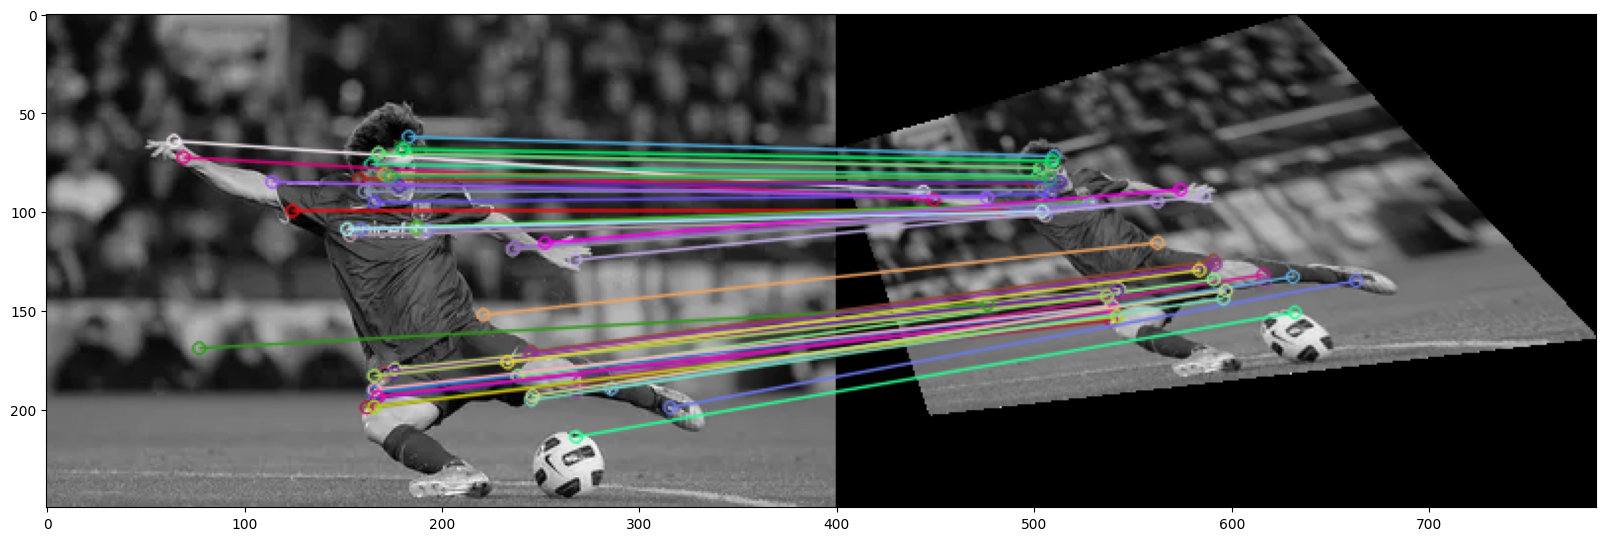

In [30]:
# Draw the matches on the images, display the results
img_matches = cv2.drawMatches(grayscale_original, keypoints1, grayscale_match, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (20,10))
plt.imshow(img_matches)